# Train your model in PyTorch
## Introduction
In past videos, we've discussed and demonstrated:
* Building models with the neural network layers and functions of the torch.nn module
* The mechanics of automated gradient computation, which is central to gradient-based model training
* Using TensorBoard to visualize training progress and other activities

In this video, we'll be adding some new tools to your inventory:
* We'll get familiar with the dataset and dataloader abstractions, and how they ease the process of feeding data to your model during a training loop
* We'll discuss specific loss functions and when to use them
* We'll look at PyTorch optimizers, which implement algorithms to adjust model weights based on the outcome of a loss function

Finally, we'll pull all of these together and see a full PyTorch training loop in action.

## Dataset and DataLoader
The `Dataset` and `DataLoader` classes encapsulate the process of pulling your data from storage and exposing it to your training loop in batches.

The `Dataset` is responsible for accessing and processing single instances of data.

The `DataLoader` pulls instances of data from the `Dataset` (either automatically or with a sampler that you define), collects them in batches, and returns them for consumption by your training loop. The `DataLoader` works with all kinds of datasets, regardless of the type of data they contain.

For this tutorial, we'll be using the Fashion-MNIST dataset provided by TorchVision. We use `torchvision.transforms.Normalize()` to zero-center and normalize the distribution of the image tile content, and download both training and validation data splits.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms 

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import  datetime

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)


# Class Labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')


for X, y in validation_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

2024-03-15 22:43:05.323865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-15 22:43:06.369757: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-15 22:43:06.369797: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-03-15 22:43:09.545595: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

Shape of X [N, C, H, W]: torch.Size([4, 1, 28, 28])
Shape of y: torch.Size([4]) torch.int64
Training set has 60000 instances
Validation set has 10000 instances


As always, let's visuilize the data as a sanity check:

Sneaker Bag Shirt T-shirt/top


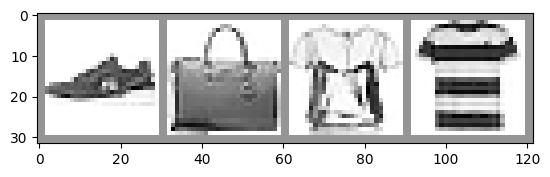

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap='Greys')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from image and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print(' '.join(classes[labels[j]] for j in range(4)))


## The Model

The model we'll use in this example is a variant of LeNet-5 - it should be familiar if you've watched the previous videos in this series.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class GarmetsClassifier(torch.nn.Module):
    def __init__(self):
        super(GarmetsClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = GarmetsClassifier()


## Loss Function

For this example, we'll be using a cross-entropy loss. For demonstration purposes, we'll create batches of dummy output and label values, run them through the loss function, and examine the result.

In [4]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])
    
print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.7232, 0.8990, 0.4327, 0.4060, 0.1297, 0.5010, 0.0393, 0.9795, 0.6805,
         0.8470],
        [0.1644, 0.5193, 0.0084, 0.1744, 0.1270, 0.6344, 0.0396, 0.9576, 0.7065,
         0.6987],
        [0.1596, 0.2075, 0.9147, 0.3530, 0.6403, 0.3927, 0.0980, 0.2540, 0.3641,
         0.9108],
        [0.5313, 0.2314, 0.8250, 0.3929, 0.6534, 0.9754, 0.8063, 0.7404, 0.6586,
         0.5430]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.193575143814087


## Optimizer

For this example, we'll be using simple [stochastic gradient descent](https://pytorch.org/docs/stable/optim.html) with momentum.

It can be instructive to try some variations on this optimization scheme:
* Learning rate determines the size of the steps the optimizer takes. What does a different learning rate do to the your training results, in terms of accuracy and convergence time?
* Momentum nudges the optimizer in the direction of strongest gradient over multiple steps. What does changing this value do to your results?
* Try some different optimization algorithms, such as averaged SGD, Adagrad, or Adam. How do your results differ?

In [5]:
# optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## The Training Loop

Below, we have a function that performs one training epoch. It enumerates data from the DataLoader, and on each pass of the loop does the following:
* Gets a batch of training data from the DataLoader
* Zeros the optimizer's gradients
* Performs an inference - that is, gets predictions from the model for an input batch
* Calculates the loss for that set of predictions vs. the labels on the dataset
* Calculates the backward gradients over the learning weights
* Tells the optimizer to perform one learning step - that is, adjust the model's learning weights based on the observed gradients for this batch, according to the optimization algorithm we chose
* It reports on the loss for every 1000 batches.
* Finally, it reports the average per-batch loss for the last 1000 batches, for comparison with a validation run

In [6]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradient for every batch
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print(' batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
    return last_loss




def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Per-Epoch Activity

There are a couple of things we'll want to do once per epoch:
* Perform validation by checking our relative loss on a set of data that was not used for training, and report this
* Save a copy of the model

Here, we'll do our reporting in TensorBoard. This will require going to the command line to start TensorBoard, and opening it in another browser tab.

In [7]:
# Initializing in a separate cell so we can easily add more epochs to same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

In [8]:
EPOCHS = 2
best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCHS {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # we don't need gradient on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
# ##########################################################################################################
    print(f"Epoch {epoch+1}\n-------------------------------")
    # train(validation_loader, model, loss_fn, optimizer)
    test(validation_loader, model, loss_fn)
    print("Done!")
 



##############################################################################################################



    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                        {'Training' : avg_loss, "Validation" : avg_vloss},
                        epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_loss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1


# epochs = 2
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     # train(validation_loader, model, loss_fn, optimizer)
#     test(validation_loader, model, loss_fn)
# print("Done!")

EPOCHS 1:
 batch 1000 loss: 1.7610293569415807
 batch 2000 loss: 0.849297079840675
 batch 3000 loss: 0.6884735265839845
 batch 4000 loss: 0.6292138978652656
 batch 5000 loss: 0.597026982538402
 batch 6000 loss: 0.5400363208572381
 batch 7000 loss: 0.5023074349754024
 batch 8000 loss: 0.501145019992604
 batch 9000 loss: 0.47335691933822815
 batch 10000 loss: 0.45111856967351194
 batch 11000 loss: 0.460300300197443
 batch 12000 loss: 0.43144813722418623
 batch 13000 loss: 0.41448006846714996
 batch 14000 loss: 0.4176484470674186
 batch 15000 loss: 0.39570670264633373
LOSS train 0.39570670264633373 valid 0.40087395906448364
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.400874 

Done!
EPOCHS 2:
 batch 1000 loss: 0.3811695868376992
 batch 2000 loss: 0.3816113203978603
 batch 3000 loss: 0.3762489689085924
 batch 4000 loss: 0.378611585455772
 batch 5000 loss: 0.3783108691283269
 batch 6000 loss: 0.3747824721833349
 batch 7000 loss: 0.37065480707769166
 bat

Switch to your open TensorBoard and have a look at the SCALARS tab.

To load a saved version of the model:

```
saved_model = GarmentClassifier()
saved_model.load_state_dict(torch.load(PATH))
```

Once you've loaded the model, it's ready for whatever you need it for - more training, inference, or analysis.

Note that if your model has constructor parameters that affect model structure, you'll need to provide them and configure the model identically to the state in which it was saved.

## Other Resources

* Docs on the [data utilities](https://pytorch.org/docs/stable/data.html), including Dataset and DataLoader, at pytorch.org
* A [note on the use of pinned memory](https://pytorch.org/docs/stable/notes/cuda.html#cuda-memory-pinning) for GPU training
* Documentation on the datasets available in [TorchVision](https://pytorch.org/docs/stable/torchvision/datasets.html), [TorchText](https://pytorch.org/text/datasets.html), and [TorchAudio](https://pytorch.org/audio/datasets.html)
* Documentation on the [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) available in PyTorch
* Documentation on the [torch.optim package](https://pytorch.org/docs/stable/optim.html), which includes optimizers and related tools, such as learning rate scheduling
* A detailed [tutorial on saving and loading models](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
* The [Tutorials section of pytorch.org](https://pytorch.org/tutorials/) contains tutorials on a broad variety of training tasks, including classification in different domains, generative adversarial networks, reinforcement learning, and more

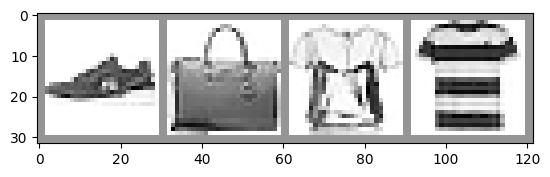

In [9]:
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

## Visualizing Your Model
TensorBoard can also be used to examine the data flow within your model. To do this, call the `add_graph()` method with a model and sample input. When you open 

In [10]:
# Write image data to TensorBoard log dir
writer.add_image('Four Fashion-MNIST Images', img_grid)
writer.add_graph(model, images)
writer.flush()

When you switch over to TensorBoard, you should see a GRAPHS tab. Double-click the "NET" node to see the layers and data flow within your model.

## Visualizing Your Dataset with Embeddings

The 28-by-28 image tiles we're using can be modeled as 784-dimensional vectors (28 * 28 = 784). It can be instructive to project this to a lower-dimensional representation. The `add_embedding()` method will project a set of data onto the three dimensions with highest variance, and display them as an interactive 3D chart. The `add_embedding()` method does this automatically by projecting to the three dimensions with highest variance.

Below, we'll take a sample of our data, and generate such an embedding:

In [11]:
# Select a random subset of data and corresponding labels
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# Extract a random subset of data
images, labels = select_n_random(training_set.data, training_set.targets)

# get the class labels for each image
class_labels = [classes[label] for label in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.flush()
writer.close()


In [12]:


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
